In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [116]:
model_df = pd.read_csv(r'C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\FrostMart\Model\model_data.csv')

In [117]:
print(model_df.head())

  Week_Number  Product_ID  Store_ID  Units_Sold  Marketing_Spend  \
0    2024-W01        1000       500        4853           670.37   
1    2024-W01        1001       500        4274          1089.62   
2    2024-W01        1002       500        4215          1004.99   
3    2024-W01        1003       500        5768           859.45   
4    2024-W01        1004       500        3403           576.70   

   Discount_Percent  Wastage_Units  Price              Product_Name  \
0                 0            718   2.46    Whole Wheat Bread 800g   
1                 0            641   1.27       White Sandwich Loaf   
2                10            632   2.74          Croissant 4-pack   
3                20            853   1.82  Blueberry Muffins 6-pack   
4                 0            503   3.46    Chocolate Chip Cookies   

  Product_Category  Shelf_Life_Days  Region  Store_Size  \
0           Bakery                4  London       12000   
1           Bakery                2  London   

In [118]:
# Create temporal index (0, 1, 2, ...) for time-based splitting later
week_map = {week: i for i, week in enumerate(model_df['Week_Number'].unique().tolist())}
model_df['Time_Index'] = model_df['Week_Number'].map(week_map)

In [119]:
# --- ML PRE-PROCESSING ---
df_ml = model_df.copy()
df_ml = df_ml.drop(columns=['Product_Name', 'Supplier_Name'])

In [120]:
print(df_ml.head())


  Week_Number  Product_ID  Store_ID  Units_Sold  Marketing_Spend  \
0    2024-W01        1000       500        4853           670.37   
1    2024-W01        1001       500        4274          1089.62   
2    2024-W01        1002       500        4215          1004.99   
3    2024-W01        1003       500        5768           859.45   
4    2024-W01        1004       500        3403           576.70   

   Discount_Percent  Wastage_Units  Price Product_Category  Shelf_Life_Days  \
0                 0            718   2.46           Bakery                4   
1                 0            641   1.27           Bakery                2   
2                10            632   2.74           Bakery                2   
3                20            853   1.82           Bakery                4   
4                 0            503   3.46           Bakery                4   

   Region  Store_Size  Cold_Storage_Capacity  Lead_Time_Days  Supply_Capacity  \
0  London       12000              

In [121]:
# Feature Engineering: Cyclic Encoding
df_ml['Week_Num'] = df_ml['Week_Number'].str.split('-W').str[1]
df_ml['Week_Num'] = pd.to_numeric(df_ml['Week_Num'], errors='coerce').fillna(1).astype(int) 
MAX_WEEKS = 53
df_ml['Week_sin'] = np.sin(2 * np.pi * df_ml['Week_Num'] / MAX_WEEKS)
df_ml['Week_cos'] = np.cos(2 * np.pi * df_ml['Week_Num'] / MAX_WEEKS)
df_ml = df_ml.drop(columns=['Week_Number', 'Week_Num'])

In [122]:
print(df_ml.head())

   Product_ID  Store_ID  Units_Sold  Marketing_Spend  Discount_Percent  \
0        1000       500        4853           670.37                 0   
1        1001       500        4274          1089.62                 0   
2        1002       500        4215          1004.99                10   
3        1003       500        5768           859.45                20   
4        1004       500        3403           576.70                 0   

   Wastage_Units  Price Product_Category  Shelf_Life_Days  Region  Store_Size  \
0            718   2.46           Bakery                4  London       12000   
1            641   1.27           Bakery                2  London       12000   
2            632   2.74           Bakery                2  London       12000   
3            853   1.82           Bakery                4  London       12000   
4            503   3.46           Bakery                4  London       12000   

   Cold_Storage_Capacity  Lead_Time_Days  Supply_Capacity  Avg_Tempe

In [123]:
# Categorical Encoding

ohe_cols = ['Store_ID', 'Region', 'Product_Category', 'Holiday_Flag']
for col in ohe_cols:
    df_ml[col] = df_ml[col].astype(str)
df_ml = pd.get_dummies(df_ml, columns=ohe_cols, drop_first=True)


In [124]:
print(df_ml.head())

   Product_ID  Units_Sold  Marketing_Spend  Discount_Percent  Wastage_Units  \
0        1000        4853           670.37                 0            718   
1        1001        4274          1089.62                 0            641   
2        1002        4215          1004.99                10            632   
3        1003        5768           859.45                20            853   
4        1004        3403           576.70                 0            503   

   Price  Shelf_Life_Days  Store_Size  Cold_Storage_Capacity  Lead_Time_Days  \
0   2.46                4       12000                   3788               3   
1   1.27                2       12000                   3788               3   
2   2.74                2       12000                   3788               2   
3   1.82                4       12000                   3788               2   
4   3.46                4       12000                   3788               2   

   ...  Store_ID_514  Region_Midlands  Regio

In [125]:
# Frequency Encoding for Product_ID


product_counts = df_ml['Product_ID'].value_counts()
df_ml['Product_ID_FreqEncoded'] = df_ml['Product_ID'].map(product_counts)
# Drop the original Product_ID string column after encoding
df_ml = df_ml.drop(columns=['Product_ID'])

In [126]:
print(df_ml.head())

   Units_Sold  Marketing_Spend  Discount_Percent  Wastage_Units  Price  \
0        4853           670.37                 0            718   2.46   
1        4274          1089.62                 0            641   1.27   
2        4215          1004.99                10            632   2.74   
3        5768           859.45                20            853   1.82   
4        3403           576.70                 0            503   3.46   

   Shelf_Life_Days  Store_Size  Cold_Storage_Capacity  Lead_Time_Days  \
0                4       12000                   3788               3   
1                2       12000                   3788               3   
2                2       12000                   3788               2   
3                4       12000                   3788               2   
4                4       12000                   3788               2   

   Supply_Capacity  ...  Region_Midlands  Region_North East  \
0            48776  ...            False             

In [127]:
# Final Data Split and Scaling
X_final = df_ml.drop(columns=['Units_Sold'])
y_final = df_ml['Units_Sold']
numerical_cols = X_final.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
X_final[numerical_cols] = scaler.fit_transform(X_final[numerical_cols])

In [128]:
# Separate features and target
X_base = df_ml.drop(columns=['Units_Sold'])
y_base = df_ml['Units_Sold']
time_index = X_base['Time_Index']
X_base = X_base.drop(columns=['Time_Index']) 

In [129]:
#Scaling numerical features
numerical_cols = X_base.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
X_final = X_base.copy()
X_final[numerical_cols] = scaler.fit_transform(X_base[numerical_cols])

In [130]:
#  SelectKBest with mutual_info_regression
k_features = 15
selector = SelectKBest(score_func=mutual_info_regression, k=k_features)
selector.fit(X_final, y_base)

# Get selected features
selected_features_mask = selector.get_support()
X_selected = X_final.iloc[:, selected_features_mask]

# Print ranked scores
feature_scores = pd.DataFrame({
    'Feature': X_final.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)
print("\n--- Feature Selection: Top Scores (mutual_info_regression) ---")
print(feature_scores.head(k_features))


--- Feature Selection: Top Scores (mutual_info_regression) ---
                       Feature     Score
2                Wastage_Units  3.514289
4              Shelf_Life_Days  0.244953
34       Product_Category_Meat  0.213193
33      Product_Category_Dairy  0.165507
3                        Price  0.159362
6        Cold_Storage_Capacity  0.136981
5                   Store_Size  0.133286
10                    Rainfall  0.082220
9              Avg_Temperature  0.075486
8              Supply_Capacity  0.071605
32  Product_Category_Beverages  0.032648
0              Marketing_Spend  0.031050
31           Region_South West  0.030989
11                    Week_sin  0.026314
21                Store_ID_509  0.023224


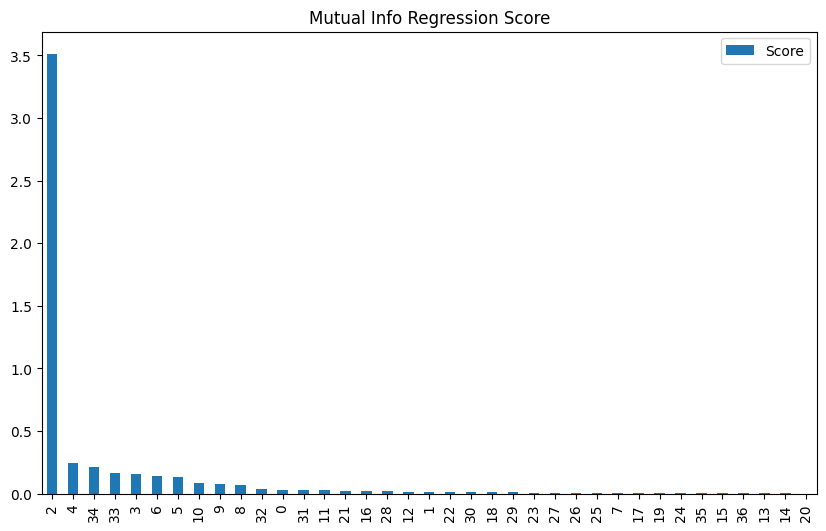

In [136]:
feature_scores.plot(kind='bar',figsize=(10,6))
plt.title('Mutual Info Regression Score')
plt.show()

In [ ]:
# TEMPORAL DATA SPLIT


print("\n--- 4. Temporal Data Split (80% Train / 20% Val) ---")

train_ratio = 0.8
unique_time_steps = time_index.unique()
split_point = int(train_ratio * len(unique_time_steps))
split_index_value = unique_time_steps[split_point]

X_train = X_selected[time_index < split_index_value]
X_val = X_selected[time_index >= split_index_value]
y_train = y_base[time_index < split_index_value]
y_val = y_base[time_index >= split_index_value]

print(f"Training set size: {len(X_train)} | Validation set size: {len(X_val)}")
print(f"Features used for training: {X_train.columns.tolist()}")


--- 4. Temporal Data Split (80% Train / 20% Val) ---
Training set size: 29520 | Validation set size: 7920
Features used for training: ['Marketing_Spend', 'Wastage_Units', 'Price', 'Shelf_Life_Days', 'Store_Size', 'Cold_Storage_Capacity', 'Supply_Capacity', 'Avg_Temperature', 'Rainfall', 'Week_sin', 'Store_ID_504', 'Region_South West', 'Product_Category_Beverages', 'Product_Category_Dairy', 'Product_Category_Meat']


In [ ]:
#  MODEL TRAINING AND EVALUATION


print("\n--- 5. Model Training and Evaluation ---")

all_metrics = []

# Define evaluation function inline (or as a helper lambda)
def get_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': model_name, 
        'RMSE': round(rmse, 4), 
        'MAE': round(mae, 4), 
        'R2': round(r2, 4)
    }

# Model 1: Ridge Regression (Linear Baseline)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_val)
all_metrics.append(get_metrics(y_val, y_pred_ridge, 'Ridge Regression'))

# Model 2: Random Forest Regressor (Non-linear Model)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
all_metrics.append(get_metrics(y_val, y_pred_rf, 'Random Forest Regressor'))

# Final Summary
df_metrics = pd.DataFrame(all_metrics).set_index('Model')

print("\n==============================================")
print("FINAL MODEL COMPARISON (Panel Data)")
print("==============================================")
print(df_metrics)


--- 5. Model Training and Evaluation ---

FINAL MODEL COMPARISON (Panel Data)
                             RMSE       MAE      R2
Model                                              
Ridge Regression         478.1147  312.4033  0.8296
Random Forest Regressor   38.0770   13.0242  0.9989
